<a href="https://colab.research.google.com/github/Imperial-lord/sdn-controllers-load-balancing/blob/main/SDN_Controller_Load_Balancing_Averaged_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
####### Graph Building using data from Arnes.gml ########
import networkx as nx
import time
import random
import math
import numpy as np
import pandas as pd

from math import radians, cos, sin, asin, sqrt
from collections import defaultdict
import matplotlib.pyplot as plt
from statistics import mean

k_list = [2,3,4,5]
discrete_coeff_list_gr_all, discrete_coeff_list_rn_all, discrete_coeff_list_QL_all = [], [], []

for i in range(0,len(k_list)):
    ####### Data collection, cleaning, and handling corner cases #######

    k = k_list[i]
    start = time.time()
    graph = nx.read_gml('/content/drive/MyDrive/BTP Documents/Arnes.gml', label='id')

    lat = nx.get_node_attributes(graph, "Latitude")
    lon = nx.get_node_attributes(graph, "Longitude")

    # Remove bad nodes from 'graph'
    for node in list(graph.nodes):
        # removing nodes 
        # (a) with undefined latitude or longitude  
        # (b) that are isolated
        check_bad_node = lat.get(node) == None or lon.get(node) == None or nx.is_isolate(graph,node)
        if check_bad_node == True:
            graph.remove_node(node)


    def dist_between_nodes(node_1, node_2):
        '''Compute distance between any 2 nodes of 'graph' using Haversine formula

        Args:
            node_1 (int): The first among the 2 graph nodes 
            node_2 (int): The second among the 2 graph nodes 

        Returns:
            dist: distanct between the two nodes
        '''
        lat_1 = radians(lat.get(node_1))
        lat_2 = radians(lat.get(node_2))
        lon_1 = radians(lon.get(node_1))
        lon_2 = radians(lon.get(node_2))

        # Applying Haversine formula
        dlon = lon_2 - lon_1
        dlat = lat_2 - lat_1
        a = sin(dlat/2)**2 + cos(lat_1)*cos(lat_2)*sin(dlon/2)**2
        c = 2*asin(sqrt(a))

        # Mean radius of Earth
        R = 6371.009
        dist = c*R

        return dist

    # Assigning weights (based on distance) to the edges of the graph
    for node in list(graph.nodes):
        for neighbor in list(graph.neighbors(node)):
            graph[node][neighbor]['weight'] = dist_between_nodes(node, neighbor)

    # Removing edges with no weights assigned
    for edge in list(graph.edges):
        if 'weight' not in graph.edges[edge] == False:
            graph.remove_edge(edge[0],edge[1])

    print(nx.info(graph))
    n = nx.number_of_nodes(graph)

    ####### Graph building and Controllers' Cluster formation #######

    # Store the graph as an adjacency list
    adj_list = [];
    for i in range(0,n):
        adj_list.append([])

    for edge in graph.edges:
        i,j = edge
        adj_list[i].append(j)
        adj_list[j].append(i)

    # Random sampling for controller index selection
    controllers = random.sample(range(0,n),k)

    # List of lists represents index of switches in particular controller 
    # e.g. [[s1,s2],[s3,s4],[s5]] controller distribution set
    lol = []
    for i in range(0,k):
        lol.append([])

    # Controllers set
    # Keeping copies for Greedy approach and Q-learning
    controllers_Q = list(controllers)
    controllers_G = list(controllers)
    print("\nControllers: \n{}\n".format(controllers))

    def BFS(queue, adj_list, listx):
        '''Performs a breadth first search in the graph
        '''
        while queue:
            p = queue.pop(0)
            u, w = p
            for v in adj_list[u]:
                if listx[v] == math.inf:
                    listx[v] = w + 1
                    queue.append((v, w + 1))
        return listx

    index = 0
    for j in range(0, k):
        listx = n*[math.inf]
        listx[controllers[index]] = 0
        queue = []
        queue.append((controllers[index], 0))
        listx = BFS(queue, adj_list, listx)
        lol[j] = listx
        index += 1

    transpose_list = np.transpose(lol).tolist()
    minumum_pos = []

    for x in transpose_list:
        min_ele = n+5
        for i in range(0, len(x)):
            if x[i] < min_ele:
                min_ele = x[i]
        ts = []
        for i in range(0, len(x)):
            if(x[i] == min_ele):
                ts.append(i)
        minumum_pos.append(random.choice(ts))

    final = []
    controller_sets = []
    for i in range(0, k):
        controller_sets.append([])

    for i in range(0, n):
        final.append((i, controllers[minumum_pos[i]]))
        controller_sets[minumum_pos[i]].append(i)

    print('Cluster set for each controller: \n{}\n'.format(controller_sets))
    controller_maps = {}
    index = 0

    for controller_set in controller_sets:
        switch_array, controller = [], controllers[index]
        for switch in controller_set:
            if switch != controller:
                switch_array.append(switch)
        controller_maps[controller] = switch_array
        index += 1 

    print('Cluster map for each controller: \n{}\n'.format(controller_maps))

    def floyd_warshall(graph):
        d = defaultdict(set)
        cnt = defaultdict(set)
        inf = float('inf')

        # Initialising distance between all nodes as infinity
        for node1 in graph.nodes:
            for node2 in graph.nodes:
                d[(node1, node2)] = inf
                cnt[(node1, node2)] = inf

        # Changing the distance between adjacent nodes
        for edge in graph.edges:
            # Undirected graph
            d[(edge[0], edge[1])] = graph.edges[edge]['weight']
            d[(edge[1], edge[0])] = graph.edges[edge]['weight']
            cnt[(edge[0], edge[1])] = 1
            cnt[(edge[1], edge[0])] = 1

        for node in graph.nodes:
            d[(node, node)] = 0
            cnt[(node, node)] = 0

        # Updating the matrix
        for node1 in graph.nodes:
            for node2 in graph.nodes:
                for node3 in graph.nodes:
                    if d[(node2, node3)] > d[(node2, node1)] + d[(node1, node3)]:
                        d[(node2, node3)] = d[(node2, node1)] + d[(node1, node3)]
                        d[(node3, node2)] = d[(node2, node3)]
                        cnt[(node2, node3)] = cnt[(node2, node1)] + cnt[(node1, node3)]
                        cnt[(node3, node2)] = cnt[(node2, node3)]

        return [d, cnt]


    [dist, hop_count] = floyd_warshall(graph)

    print('Having used Floyd Warshall algorithm, we obtain the following - (i) Dist and (ii) Hop Count')
    print(dist)
    print(hop_count)

    # Keeping another copy of the controller set for Greedy approach
    controller_sets_G = list(controller_sets)
    print(controller_sets_G)

    # Keeping another copy of the controller set for Q-learning
    controller_sets_Q = list(controller_sets)
    print(controller_sets_Q)

    frame = pd.read_csv('/content/drive/MyDrive/BTP Documents/data.csv')
    nodes = list(graph.nodes)
    # random.shuffle(nodes)
    frame = frame.rename(columns=dict(zip(frame.columns, nodes)))

    load_array = [] # Array of maps, with each node mapped to a load
    for i in frame.index:
        Load = dict(frame.loc[i])
        load_array.append(Load)
        

    # Switch Migration Design
    '''
    LCi: the load of the controller Ci
    CCi: the load capacity of the controller Ci
    RCi: the load ratio of the controller Ci
    LSk: the packet-in message sending rate of the switch Sk
    R: mean load ratio of all controllers
    D: load ratio deviation coefficient between two controllers
    E: migrate switch efficiency between controllers
    HSk: number of hops between the switch and the controller
    '''

    # A. Load Balancing

    '''
    Controllers' Load
    Populating `controller_cluster_load` array
    Eg - {c1:36363663, c2:3234325, c3:32523525, c4:3523535, c5:3542646}
    Load for a controller is the sum of load on it + all it's switches
    '''

    def calculate_controller_cluster_load(time_step, controller_sets):
        controller_cluster_load = {}
        index = 0 
        for controller_set in controller_sets:
            total_load = 0
            for switch in controller_set:
                total_load += load_array[time_step][switch]

            controller_cluster_load[controllers[index]] = total_load
            index += 1
        return controller_cluster_load

    # TEST ABOVE FUNCTION --------------------------------------
    # controller_cluster_load = calculate_controller_cluster_load(0, controller_sets)
    # print(controller_cluster_load)
    # -----------------------------------------------------------

    '''
    Controllers' Load Capacity
    For finding this, we assume the extreme most case, i.e, number of controllers = 1
    For this, the load capacity at a given time step = sum of all load on all switches at that time step.
    The `load capacity of all controllers` = max of the load capacity over all time steps, and assumed to be uniform for all controllers.
    '''

    def calculate_controller_load_capacity():
        load_capacity_at_ts = []
        for time_step in range(0,len(load_array)):
            values = load_array[time_step].values()
            total = sum(values)
            load_capacity_at_ts.append(total)
        return max(load_capacity_at_ts)

    CONTROLLERS_LOAD_CAPACITY = calculate_controller_load_capacity()

    '''
    Controllers' Load Ratio
    The `load ratio for a controller` is the ratio of it's load to load capacity
    '''

    def calculate_controller_cluster_load_ratio(controller_cluster_load):
        controller_cluster_load_ratio = {}
        for controller in controller_cluster_load:
            controller_cluster_load_ratio[controller] = controller_cluster_load[controller]/CONTROLLERS_LOAD_CAPACITY
        return controller_cluster_load_ratio

    # TEST ABOVE FUNCTION ---------------------------------------
    # controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
    # print(controller_cluster_load_ratio)
    # -----------------------------------------------------------

    '''
    Controllers' Mean Load Ratio
    The mean load ratio of controllers is given as mean of load ratios of all controllers
    '''

    def calculate_controller_mean_load_ratio(controller_cluster_load_ratio):
        values = controller_cluster_load_ratio.values()
        no_of_controllers = len(values)
        controller_mean_load_ratio = sum(values)/no_of_controllers
        return controller_mean_load_ratio

    # TEST ABOVE FUNCTION ---------------------------------------
    # controller_mean_load_ratio = calculate_controller_mean_load_ratio(controller_cluster_load_ratio)
    # print(controller_mean_load_ratio)
    # -----------------------------------------------------------

    '''
    Discrete Coefficient 
    The discrete coefficient is used to describe the degree of discrete of 
    the controller’s load ratio and the mean load ratio between controllers
    '''

    def calculate_discrete_coefficient(controller_cluster_load_ratio):
        controller_mean_load_ratio = calculate_controller_mean_load_ratio(controller_cluster_load_ratio)
        D_num = 0
        D_denom = controller_mean_load_ratio
        no_of_controllers = len(controller_cluster_load_ratio.values())

        for controller in controller_cluster_load_ratio:
            load_ratio = controller_cluster_load_ratio[controller]
            D_num += ((load_ratio - controller_mean_load_ratio)**2)/no_of_controllers
        
        D_num = sqrt(D_num)
        D = D_num/D_denom
        return D

    # TEST ABOVE FUNCTION ---------------------------------------
    # discrete_coefficient = calculate_discrete_coefficient(controller_cluster_load_ratio)
    # print(discrete_coefficient)
    # -----------------------------------------------------------

    # B. Switch Migration Efficiency

    '''
    If the switch is migrating between controllers, there will be migration overhead. 
    Because the hop count HSk between the switch and the controller is different, 
    the load LSk of the switch to the controller is different, the migration efficiency 
    is expressed as the ratio of these 2 quantities: E(Ci, Sk) = LSk / HSk
    '''

    def calculate_switch_migration_efficiency(time_step, controller_sets):
        switch_migration_efficiency = {}
        index = 0

        for controller_set in controller_sets:
            controller = controllers[index]
            ECi = {}
            for switch in controller_set:
                if switch != controller:
                    LSk = load_array[time_step][switch]
                    HSk = hop_count[(controller, switch)]
                    ECi[switch] = LSk/HSk
            switch_migration_efficiency[controller] = ECi
            index += 1

        return switch_migration_efficiency

    # TEST ABOVE FUNCTION ---------------------------------------
    # switch_migration_efficiency = calculate_switch_migration_efficiency(0, controller_sets)
    # print(switch_migration_efficiency)

    # mean_switch_migration_efficiency = {}
    # for controller in switch_migration_efficiency:
    #     values = switch_migration_efficiency[controller].values()
    #     l = len(values)
    #     if l==0:
    #         mean_switch_migration_efficiency[controller] = 0
    #     else:
    #         mean_switch_migration_efficiency[controller] = sum(values)/l
    # print(mean_switch_migration_efficiency)
    # -----------------------------------------------------------

    # C. Migration Tuples Selection

    # a. Migration Domain Selection:

    ''' 
    In a real-time changing network environment, the load of each controller also changes
    fast. The traditional method tends to strip the selection process of the out-migration domain 
    and the in-migration domain, which introduces the probability of controller overload to some
    extents, while it is also easy to bring migration conflicts and migration jitter in the 
    control plane. Next, a new selection algorithm will be proposed and which will add anti-collision
    mechanism in the judgment part to avoid the two consequences of the commonly bad migration. 
    The switch migration domain selection algorithm is as follows:
    '''

    def select_migration_domain(controller_cluster_load_ratio, controller_mean_load_ratio, discrete_coefficient):
        out_migration_domain, in_migration_domain, migration_queue = set(), set(), set()
        D = discrete_coefficient 
        R_mean = controller_mean_load_ratio

        for Ci, RCi in controller_cluster_load_ratio.items():
            for Cj, RCj in controller_cluster_load_ratio.items():
                if Ci!=Cj:
                    D_CiCj = calculate_discrete_coefficient({Ci: RCi, Cj: RCj})

                    if D_CiCj > D and RCi > R_mean and RCi > RCj:
                        out_migration_domain.add(Ci)
                        in_migration_domain.add(Cj)
                        migration_queue.add((Ci,Cj))
                    if D_CiCj < D and RCi < R_mean and RCi < RCj:
                        out_migration_domain.add(Cj)
                        in_migration_domain.add(Ci)
                        migration_queue.add((Cj,Ci))
                    if D_CiCj == D:
                        if RCi < R_mean and RCi < RCj:
                            out_migration_domain.add(Cj)
                            in_migration_domain.add(Ci)
                            migration_queue.add((Cj,Ci))
                        if RCi > R_mean and RCi > RCj:
                            out_migration_domain.add(Ci)
                            in_migration_domain.add(Cj)
                            migration_queue.add((Ci,Cj))
        
        return out_migration_domain, in_migration_domain, migration_queue

    # TEST ABOVE FUNCTION ---------------------------------------
    # out_migration_domain, in_migration_domain, migration_queue = select_migration_domain(controller_cluster_load_ratio, controller_mean_load_ratio, discrete_coefficient)
    # print(out_migration_domain) 
    # print(in_migration_domain) 
    # print(migration_queue)
    # -----------------------------------------------------------

    # C. Migration Tuples Selection

    # b. Migration Switch Selection: 

    '''
    For each migration queue Q that will be migrating, the migration switch selected by the algorithm is defined 
    as the fastest reduction of the factor of the load ratio under the best efficiency ECi,Sk in migration.
    The switches under the out-migration controller are sorted according to the migration efficiency, 
    the higher the efficiency of the switch migration, the higher the possibility of being selected. 
    A switch combination managed by the out-migration controller, whose migration efficiency of each 
    switch has greater than the average efficiency in migration and arranged by size, which is finding 
    out by the selection algorithm. 
    It is the optimal migration switch combination when it maximizes the reduction of the discrete coefficients 
    between controllers. The specific algorithm of selecting migrating switch is as follows:
    '''

    def select_migrating_switch(controller_sets_input, controller_cluster_load_ratio, migration_queue, time_step, switch_migration_efficiency):
        # migration_tuples = set()
        migration_tuples = []
        n, Q = 0, migration_queue

        for q in Q:
            Ci, Cj = q
            ECiS = 0
            L, S_collection = {}, []
            S = controller_sets_input[controllers_G.index(Ci)]
            # Remove the controller from the list of switches since it the hop count for it is 0
            if  Ci in S:
                S.remove(Ci)
            n = len(S)

            for Sk in S:
                ECiS += switch_migration_efficiency[Ci][Sk]
                L[Sk]=switch_migration_efficiency[Ci][Sk]

            L = dict(sorted(L.items(), key=lambda x: x[1], reverse=True))
            ECiS_mean = ECiS/(n+1) # correct this !!!
            k = 1

            LSk_sum = 0
            for Sk in L:
                LSk = load_array[time_step][Sk]
                LSk_sum += LSk*((Ci+1)/(Cj+1))

            RCi_dash, RCj_dash = controller_cluster_load_ratio[Ci]+LSk_sum, controller_cluster_load_ratio[Cj]+LSk_sum
            RCiCj_mean = (controller_cluster_load_ratio[Ci] + controller_cluster_load_ratio[Cj])/2
            DCiCj_num = ((RCi_dash - RCiCj_mean)**2 + (RCj_dash - RCiCj_mean)**2)/2
            DCiCj_num = sqrt(DCiCj_num)
            DCiCj_dash = DCiCj_num/RCiCj_mean

            temp = math.inf
            for Sk in L:
                ECiSk = switch_migration_efficiency[Ci][Sk]
                if ECiSk >= ECiS_mean and DCiCj_dash < temp:
                    k+=1
                    temp = DCiCj_dash
                    S_collection.append(Sk)
                else:
                    break

            migration_tuples.append((Ci,Cj,S_collection))

        return migration_tuples

    # TEST ABOVE FUNCTION ---------------------------------------
    # migration_tuples = select_migrating_switch(controller_cluster_load_ratio,migration_queue,0, switch_migration_efficiency)
    # print(migration_tuples)
    # print(controller_sets)
    # print(controller_sets_G)
    # -----------------------------------------------------------
    '''
    Implement a purely greedy approach using the above function from the research paper.
    '''

    def load_rate(controller_cluster_load_ratio, controller_mean_load_ratio, no_of_controllers):
        '''
        Find the load rate for controllers
        '''
        s = 0
        for current_controller, controller_load in controller_cluster_load_ratio.items():
            s = s + abs(controller_load - controller_mean_load_ratio)
        s /= no_of_controllers
        return s

    # For making graph
    time_steps_list_gr = []
    load_balance_rate_list_gr = []
    discrete_coeff_list_gr = []
    number_of_switches_list_gr = []

    load_rate_list_gr = []


    for i in range(0,1000):
        print('At time step :', i)
        
        # Store the controller load ratios for each controller
        # print(controller_sets)
        controller_cluster_load = calculate_controller_cluster_load(i, controller_sets_G)
        controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
        controller_mean_load_ratio = calculate_controller_mean_load_ratio(controller_cluster_load_ratio)

        # Calculate the discrete coefficient
        discrete_coefficient = calculate_discrete_coefficient(controller_cluster_load_ratio)

        out_migration_domain, in_migration_domain, migration_queue = select_migration_domain(controller_cluster_load_ratio, controller_mean_load_ratio, discrete_coefficient)
        switch_migration_efficiency = calculate_switch_migration_efficiency(i, controller_sets_G)
        print(switch_migration_efficiency)
        print(migration_queue)
        migration_tuples = select_migrating_switch(controller_sets_G, controller_cluster_load_ratio, migration_queue, i, switch_migration_efficiency)

        switch_array = []

        for each_tuple in migration_tuples:
            index_of_overloaded_controller, target_controller_index = controllers_G.index(each_tuple[0]), controllers_G.index(each_tuple[1]) 
            current_switch = each_tuple[2][0]
            
            print(each_tuple)
            print(controller_sets_G)
            print(current_switch)
            
            if(current_switch in controller_sets_G[index_of_overloaded_controller]):
                controller_sets_G[index_of_overloaded_controller].remove(current_switch)
                controller_sets_G[target_controller_index].append(current_switch)

            switch_array.append(current_switch)


        l_rate = load_rate(controller_cluster_load_ratio, controller_mean_load_ratio, k)
        discrete_coeff = calculate_discrete_coefficient(controller_cluster_load_ratio)

        time_steps_list_gr.append(i)
        load_balance_rate_list_gr.append(l_rate)
        discrete_coeff_list_gr.append(discrete_coeff)
        number_of_switches_list_gr.append(len(switch_array))

        load_rate_list_gr.append([l_rate, len(switch_array)])

        print('At time step', i, 'the number of switch migrated are :', len(switch_array))
        print('The migrated switches are', switch_array)
        print('\n---------------------------------------------------------------------------------------------------------------------------\n')
    
    # store values for a given k
    discrete_coeff_list_gr_all.append(discrete_coeff_list_gr)

    '''
    To compare with the Q-learning based implementation, we have to make a random approach of selecting and assigning 
    switches and hope to balance the load between the controller.
    '''

    def select_random_switch(index_of_overloaded_controller, current_controller):
        '''
        Select a switch randomly from the controller. 
        Ensure that the controller itself is not selected
        '''
        if(len(controller_sets[index_of_overloaded_controller]) == 1):
            return -1
        x = random.choice(controller_sets[index_of_overloaded_controller])
        # To avoid controller to be selected itself
        while(x == current_controller):
            x = random.choice(controller_sets[index_of_overloaded_controller])
        return x

    def load_rate(controller_cluster_load_ratio, controller_mean_load_ratio, no_of_controllers):
        '''
        Find the load rate for controllers
        '''
        s = 0
        for current_controller, controller_load in controller_cluster_load_ratio.items():
            s = s + abs(controller_load - controller_mean_load_ratio)
        s /= no_of_controllers
        return s

    def random_action(available_act, controller):
        '''
        Radomly choose the next action
        Ensure that the controller itself is not choosen
        '''
        next_action = int(np.random.choice(available_act, 1))
        while(next_action == controller):
            next_action = int(np.random.choice(available_act, 1))
        return next_action


    # For making graph
    time_steps_list_rn = []
    load_balance_rate_list_rn = []
    discrete_coeff_list_rn = []
    number_of_switches_list_rn = []

    load_rate_list_rn = []
    migration_cost_random = 0
    migration_array_random = []
    normalize = 10**9

    for i in range(0, 1000):
        print('At time step :', i)
        
        # Store the controller load ratios for each controller
        # print(controller_sets)
        controller_cluster_load = calculate_controller_cluster_load(i, controller_sets)
        controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
        controller_mean_load_ratio = calculate_controller_mean_load_ratio(controller_cluster_load_ratio)

        # Calculate the discrete coefficient
        discrete_coefficient = calculate_discrete_coefficient(controller_cluster_load_ratio)
        # print(discrete_coefficient)
        # print(controller_cluster_load, controller_cluster_load_ratio, controller_mean_load_ratio, discrete_coefficient)

        switch_array = []

        # Classify the domains as overloaded and underloaded (O-Domain and I-Domain)
        O_domain, I_domain, migration_queue = select_migration_domain(controller_cluster_load_ratio, controller_mean_load_ratio, discrete_coefficient)
        O_domain = list(O_domain)

        print('The overloaded domains are :', O_domain)

        # Loop until there are no overloaded controllers in O_domain
        while(len(O_domain) >= 1):

            # Assign current state to a random overloaded domain
            current_state = random.choice(O_domain)
            O_domain.remove(current_state)

            while(controller_cluster_load_ratio[current_state] >= controller_mean_load_ratio):
                print('Balance the overloaded controller :', current_state)
                
                print('Controller\tController Load Ratio')
                for C,C_load_ratio in controller_cluster_load_ratio.items():
                    print(C, ':\t', C_load_ratio)
                
                # Select switch to migrate from selected overloaded controller
                index_of_overloaded_controller = controllers_Q.index(current_state)
                current_switch = select_random_switch(index_of_overloaded_controller, current_state)
                
                # Print all the switches of the overloaded controller
                print('Switches in the controller', current_state, ':', controller_sets[index_of_overloaded_controller])

                # Controller can't be balanced by switch migration if it has no switches on it
                if(current_switch == -1):
                    break
                
                print('Switch selected is :', current_switch)
                switch_array.append(current_switch)

                # Find domains that are currently underloaded
                underloaded_domain = [item for item in range(0, k)]

                target_controller_index = random_action(underloaded_domain, index_of_overloaded_controller)
                target_state = controllers[target_controller_index]

                print('The target controller set for {} is : {}'.format(target_state, controller_sets[target_controller_index]))
                print('The mean load ratio is :', controller_mean_load_ratio)

                # Migrate the selected switch
                controller_sets[index_of_overloaded_controller].remove(current_switch)
                controller_sets[target_controller_index].append(current_switch)

                # Update the loads
                controller_cluster_load_ratio[current_state] -= (load_array[i][current_switch]/CONTROLLERS_LOAD_CAPACITY)
                controller_cluster_load_ratio[target_state] += (load_array[i][current_switch]/CONTROLLERS_LOAD_CAPACITY)
                print()

        
        l_rate = load_rate(controller_cluster_load_ratio, controller_mean_load_ratio, k)
        discrete_coeff = calculate_discrete_coefficient(controller_cluster_load_ratio)

        discrete_coeff_list_rn.append(discrete_coeff)
        time_steps_list_rn.append(i)
        load_balance_rate_list_rn.append(l_rate)
        number_of_switches_list_rn.append(len(switch_array))

        load_rate_list_rn.append([l_rate, len(switch_array)])

        print('At time step', i, 'the number of switch migrated are :', len(switch_array))
        print('The migrated switches are', switch_array)
        print('\n---------------------------------------------------------------------------------------------------------------------------\n')

    discrete_coeff_list_rn_all.append(discrete_coeff_list_rn)

    '''
    When the migration efficiency can’t be optimized by using the greedy strategy only
    to make decisions, exploring non-greedy situations at the case of probability in each 
    decision and combining ε-greedy and decision-making to select migration triples, so as 
    to obtain global optimal switch migration decision based on reinforcement learning
    '''

    # Q-evaluation matrix with size = (k*k); k = number of controllers
    Q_matrix = np.ones([k,k])

    # Q-learning parameters
    # alpha - learning rate. gamma - discount factor
    alpha, gamma = 0.6, 0.7

    def update_Q_matrix(current_state, action, reward):
        ''' 
        Q learning formula -
        Q_matrix[current_state, action] = Q_matrix[current_state, action] + alpha*(reward + gamma*max_value - Q_matrix[current_state, action])
        The updation here is done in 2 parts -
            (a) Select the maximum Q-value in the matrix
            (b) Use the Q-learing formula to update the Q-matrix
        '''
        # (a) Select the maximum Q-value in the matrix
        list_of_max_indices = []
        max_value = max(Q_matrix[action, ])

        for i in range(0, len(Q_matrix[action, ])):
            if Q_matrix[action,i] == max_value:
                list_of_max_indices.append(i)

        # choose a random index from the list
        max_index = random.choice(list_of_max_indices) 
        max_value = Q_matrix[action,max_index]

        # (b) Use the Q-learing formula to update the Q-matrix
        Q_matrix[current_state, action] = Q_matrix[current_state, action] + alpha*(reward + gamma*max_value - Q_matrix[current_state, action])
        print('Q value =',Q_matrix[current_state, action])



    def select_max_load_switch(index, current_controller, time_step):
        '''
        The following steps are followed to select a switch to migrate:
        (a) If the controller has no switch with it, return -1
        (b) Sort the switches based on load and select the switch with max load. If that switch is the controller itself, choose the next switch.
        '''
        if(len(controller_sets_Q[index]) == 1):
            return -1

        x = controller_sets_Q[index]
        load_x = []
        for i in x:
            load_x.append((load_array[time_step][i], i))

        load_x.sort(reverse=True)
        print(load_x)
        if(load_x[0][1] == current_controller):
            return load_x[1][1]
        return load_x[0][1]


    def find_underloaded(controller_cluster_load_ratio, controller_mean_load_ratio):
        '''
        If the controller load ratios are less than mean, then they are underloaded
        '''
        I_domain = []
        for controller, controller_load_ratio in controller_cluster_load_ratio.items():
            if(controller_load_ratio < controller_mean_load_ratio):
                I_domain.append(controller)
        return I_domain

    def load_rate(controller_cluster_load_ratio, controller_mean_load_ratio, no_of_controllers):
        '''
        Find the load rate for controllers
        '''
        s = 0
        for current_controller, controller_load in controller_cluster_load_ratio.items():
            s = s + abs(controller_load - controller_mean_load_ratio)
        s /= no_of_controllers
        return s


    def sample_next_action(underloaded_domain, index_of_overloaded_controller, epsilon, Q_matrix):
        '''
        Epsilon greedy strategy - 
        Randomly generate a number. 
        (a) If it's less than epsilon : next action = random selection
        (b) If it's greater than or equal to epsilon: next action = greedy selection
        '''
        ran = np.random.random()
        next_action = -1

        if ran < epsilon:
            print('Taking a random action')
            next_action = int(np.random.choice(underloaded_domain, 1))
            while(next_action == index_of_overloaded_controller):
                next_action = int(np.random.choice(underloaded_domain, 1))
        else:
            ls = []
            for i in underloaded_domain:
                ind = controllers_Q.index(i)
                if ind != index_of_overloaded_controller:
                    ls.append(ind)

            max_ele = Q_matrix[index_of_overloaded_controller][ls[0]]
            next_action = controllers_Q[ls[0]]

            if len(ls) > 1:
                for i in range(1, len(ls)):
                    if max_ele < Q_matrix[index_of_overloaded_controller][ls[i]]:
                        max_ele = Q_matrix[index_of_overloaded_controller][ls[i]]
                        next_action = controllers_Q[ls[i]]
        return next_action


    # For making graph
    time_steps_list_QL = []
    load_balance_rate_list_QL = []
    number_of_switches_list_QL = []
    discrete_coeff_list_QL = []
    reward_list = []
    load_rate_list_QL = []

    epsilon = 0.7
    epsilon_dec = 0.0025
    epsilon_min = 0.05

    load_controller = []

    for i in range(0, 1000):
        print('At time step :', i)
        
        # Store the controller load ratios for each controller
        # print(controller_sets_Q)
        controller_cluster_load = calculate_controller_cluster_load(i, controller_sets_Q)
        controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
        controller_mean_load_ratio = calculate_controller_mean_load_ratio(controller_cluster_load_ratio)

        # Calculate the discrete coefficient
        discrete_coefficient = calculate_discrete_coefficient(controller_cluster_load_ratio)
        print(discrete_coefficient)
        # print(controller_cluster_load, controller_cluster_load_ratio, controller_mean_load_ratio, discrete_coefficient)

        switch_array = []
        reward = 0

        # Classify the domains as overloaded and underloaded (O-Domain and I-Domain)
        O_domain, I_domain, migration_queue = select_migration_domain(controller_cluster_load_ratio, controller_mean_load_ratio, discrete_coefficient)
        O_domain = list(O_domain)

        print('The overloaded domains are :', O_domain)

        # Loop until there are no overloaded controllers in O_domain
        while(len(O_domain) >= 1):

            # Assign current state to a random overloaded domain
            current_state = random.choice(O_domain)
            O_domain.remove(current_state)

            while(controller_cluster_load_ratio[current_state] >= controller_mean_load_ratio):
                print('Balance the overloaded controller :', current_state)
                
                print('Controller\tController Load Ratio')
                for C,C_load_ratio in controller_cluster_load_ratio.items():
                    print(C, ':\t', C_load_ratio)
                
                # Select switch to migrate from selected overloaded controller
                index_of_overloaded_controller = controllers_Q.index(current_state)
                current_switch = select_max_load_switch(index_of_overloaded_controller, current_state, i)
                
                # Print all the switches of the overloaded controller
                print('Switches in the controller', current_state, ':', controller_sets_Q[index_of_overloaded_controller])

                # Controller can't be balanced by switch migration if it has no switches on it
                if(current_switch == -1):
                    break
                
                print('Switch selected is :', current_switch)
                switch_array.append(current_switch)

                # Find domains that are currently underloaded
                underloaded_domain = find_underloaded(controller_cluster_load_ratio, controller_mean_load_ratio)
                print('The underloaded domains are :', underloaded_domain)

                target = sample_next_action(underloaded_domain, index_of_overloaded_controller, epsilon, Q_matrix)
                target_controller_index = controllers_Q.index(target)
                target_state = controllers_Q[target_controller_index]

                print('The target controller set for {} is : {}'.format(target_state, controller_sets_Q[target_controller_index]))
                print('The mean load ratio is :', controller_mean_load_ratio)

                # Reward calculation -
                '''
                The reward in this case is given as -
                Rij = (D'ij − Dij) / cost(St)
                '''
                R_initial = controller_cluster_load_ratio[current_state]
                R_target = controller_cluster_load_ratio[target_state]
                D_ij = calculate_discrete_coefficient({current_state: R_initial, target_state: R_target})
                # print(R_initial, R_target, D_ij)

                # Migrate the selected switch
                controller_sets_Q[index_of_overloaded_controller].remove(current_switch)
                controller_sets_Q[target_controller_index].append(current_switch)

                # Update the loads
                controller_cluster_load_ratio[current_state] -= (load_array[i][current_switch]/CONTROLLERS_LOAD_CAPACITY)
                controller_cluster_load_ratio[target_state] += (load_array[i][current_switch]/CONTROLLERS_LOAD_CAPACITY)

                R_initial = controller_cluster_load_ratio[current_state]
                R_target = controller_cluster_load_ratio[target_state]
                Dt_ij = calculate_discrete_coefficient({current_state: R_initial, target_state: R_target})
                # print(R_initial, R_target, Dt_ij)

                # reward =  (Dt_ij - D_ij)/(hop_count[(current_state, target_state)]+hop_count[(target_state, current_switch)])
                reward =  1/(Dt_ij*(hop_count[(current_state, target_state)]+hop_count[(target_state, current_switch)]))
                # 1 - research paper, 2 - cs->uc + oc->uc
                print('The reward is =', reward)
                
                # Update the Q-matrix
                update_Q_matrix(index_of_overloaded_controller, target_controller_index, reward)
                print()

        if(epsilon > epsilon_min):
            epsilon = epsilon * epsilon_dec
        else:
            epsilon = epsilon_min
        
        l_rate = load_rate(controller_cluster_load_ratio, controller_mean_load_ratio, k)
        reward_list.append(reward)
        discrete_coeff = calculate_discrete_coefficient(controller_cluster_load_ratio)

        discrete_coeff_list_QL.append(discrete_coeff)
        time_steps_list_QL.append(i)
        load_balance_rate_list_QL.append(l_rate)
        number_of_switches_list_QL.append(len(switch_array))

        load_controller.append(controller_cluster_load_ratio)
        load_rate_list_QL.append([l_rate, len(switch_array)])

        print('At time step', i, 'the number of switch migrated are :', len(switch_array))
        print('The migrated switches are', switch_array)
        print('\n---------------------------------------------------------------------------------------------------------------------------\n')
    
    discrete_coeff_list_QL_all.append(discrete_coeff_list_QL)

    # Finally print the Q_matrix   
    print(Q_matrix)


Streaming output truncated to the last 5000 lines.
[(807120.2794, 29), (513020.852, 3), (503214.0882, 1), (482269.0368, 2), (415303.3384, 24), (6208.483137, 32)]
Switches in the controller 14 : [32, 24, 29, 3, 2, 1]
Switch selected is : 29
The underloaded domains are : [4, 11, 18]
The target controller set for 18 is : [27, 9, 8, 5]
The mean load ratio is : 0.11589874879474575
The reward is = 0.9455715925745732
Q value = 37.68639615804517

Balance the overloaded controller : 18
Controller	Controller Load Ratio
4 :	 0.09036267896589271
14 :	 0.08488992664730531
6 :	 0.14894303088980326
11 :	 0.10938647755554168
18 :	 0.14591162991518578
[(807120.2794, 29), (807111.9767, 27), (697262.6498, 8), (583733.2469, 9), (404958.874, 5)]
Switches in the controller 18 : [27, 9, 8, 5, 29]
Switch selected is : 29
The underloaded domains are : [4, 14, 11]
The target controller set for 14 is : [32, 24, 3, 2, 1]
The mean load ratio is : 0.11589874879474575
The reward is = 4.460390272711815
Q value = 32.2

# **Results**

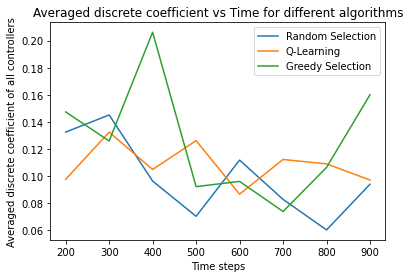

In [20]:
'''
x = []  # For storing time steps
y = []  # For averaged discrete coefficient
'''

x = []

yrandom = []
yQL = []
yGreedy = []

# Showing averaged results at each timestep
for i in range(200,1000,100):
    x.append(time_steps_list_rn[i])

    yrandom.append(mean([discrete_coeff_list_rn_all[0][i], discrete_coeff_list_rn_all[1][i], discrete_coeff_list_rn_all[2][i]]))
    yQL.append(mean([discrete_coeff_list_QL_all[0][i], discrete_coeff_list_QL_all[1][i], discrete_coeff_list_QL_all[2][i]]))
    yGreedy.append(mean([discrete_coeff_list_gr_all[0][i], discrete_coeff_list_gr_all[1][i], discrete_coeff_list_gr_all[2][i]]))

plt.plot(x, yrandom, label='Random Selection')
plt.plot(x, yQL, label='Q-Learning')
plt.plot(x, yGreedy, label='Greedy Selection')
plt.xlabel('Time steps')
plt.ylabel('Averaged discrete coefficient of all controllers')
plt.title('Averaged discrete coefficient vs Time for different algorithms')
plt.legend()
plt.show()